### Replicate Data: how to build the problem fit?

In [8]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai.basics import *
from fastai.tabular.all import *

import sklearn
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

%load_ext autoreload
%autoreload 2

from module2.mnist_helpers import build_df, build_tabular_df, build_dls
from module2.mnist_metrics import metrics_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Setup

In [59]:
path = untar_data(URLs.MNIST_TINY)
X, Y = build_tabular_df(path)

In [60]:
dls_tl = build_dls(target='topleft')

point_t = dls_tl.transform[1]
scale_t = dls_tl.after_item
def my_scale(x): return scale_t(point_t(x))

Y_sc = pd.DataFrame(
        torch.cat( ( my_scale(Y.iloc[:,1:3]), 
                     my_scale(Y.iloc[:,3:5]) ), axis=1),
        columns = Y.columns[1:])

In [72]:
restrict_cols = ["pts22_5","pts22_29","pts22_21","pts11_0",
                "pts12_4", "pts11_2"]
pts_cols      = [col for col in X.columns if 'pts' in str(col)]
all_cols      = [col for col in X.columns]

### Analyze the Structure of the data

In [73]:
tmp = X.loc[:,pts_cols]
corrs = tmp.corr().to_numpy()
corrs = corrs.flatten() 
corrs = corrs[corrs < 1]

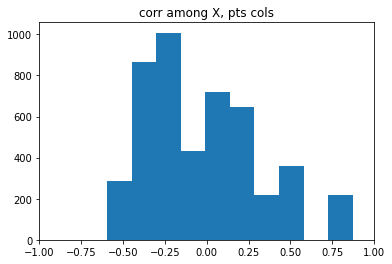

In [74]:
plt.hist(corrs);
plt.xlim(-1,1); plt.title('corr among X, pts cols');

In [78]:
y_col = 'point_topleft_y'

top_corr_y = tmp.corrwith(Y_sc[y_col])
top_corr_y[top_corr_y > 0.99]

pts11_0    1.0
pts11_2    1.0
pts12_0    1.0
pts12_2    1.0
pts12_4    1.0
pts12_6    1.0
dtype: float64

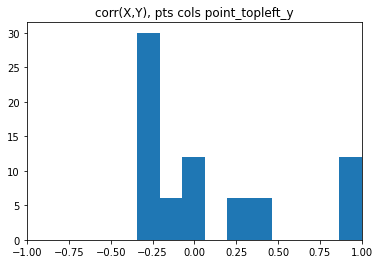

In [79]:
plt.hist(top_corr_y);
plt.xlim(-1,1); plt.title(f'corr(X,Y), pts cols {y_col}');

In [80]:
tmp = X.loc[:,all_cols]
corrs = tmp.corr().to_numpy()
corrs = corrs.flatten() 
corrs = corrs[corrs < 1]

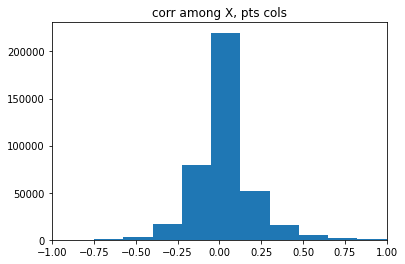

In [81]:
plt.hist(corrs);
plt.xlim(-1,1); plt.title('corr among X, pts cols');

### Build Synthetic Data

In [82]:
from sklearn.datasets import make_regression

In [142]:
reg = make_regression(
    n_samples=700,
    n_features=800,
    n_informative=60,
    n_targets=1,
    bias=0.0,
    effective_rank=None,
    tail_strength=0.5,
    noise=200.0,
    shuffle=True,
    coef=False,
    random_state=None,
)

In [ ]:
reg = make_regression(
    n_samples=700,
    n_features=800,
    n_informative=60,
    noise=200.0,
)

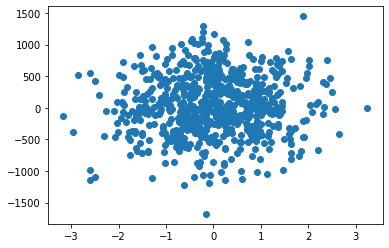

In [143]:
ind=3
plt.scatter(reg[0][:,ind], reg[1])

#### First X is related to y but with noise

In [144]:
xx, yy = reg

xxt, xxv, yyt, yyv = train_test_split(xx, yy)

In [145]:
lr = LinearRegression()
lr.fit(xxt, yyt)

lr.score(xxt, yyt), lr.score(xxv, yyv)

(1.0, 0.09069388443016857)

In [147]:
lasso = Lasso(alpha=10.)
lasso.fit(xxt, yyt)

lasso.score(xxt, yyt), lasso.score(xxv, yyv)

(0.860503957666518, 0.670396833358098)

#### Now a perfect predictors in X

In [149]:
num_perfects = 4

perfect_preds = np.array([yy + np.random.randint(-100, 100) 
                          for _ in range(num_perfects)])

In [165]:
xxp = np.concatenate((xx,perfect_preds.T), axis=1)
xxp.shape

(700, 804)

In [166]:
xxt, xxv, yyt, yyv = train_test_split(xxp, yy)

In [167]:
lr = LinearRegression()
lr.fit(xxt, yyt)

lr.score(xxt, yyt), lr.score(xxv, yyv)

(1.0, 0.9999999999983872)

In [168]:
lasso = Lasso(alpha=10.)
lasso.fit(xxt, yyt)

lasso.score(xxt, yyt), lasso.score(xxv, yyv)

(0.9999999979398241, 0.9999999979143801)

#### Analyze synthetic dataset

In [173]:
top_corr_y = pd.DataFrame(xxt).corrwith(pd.Series(yyt))
top_corr_y[top_corr_y > 0.99]

800    1.0
801    1.0
802    1.0
803    1.0
dtype: float64

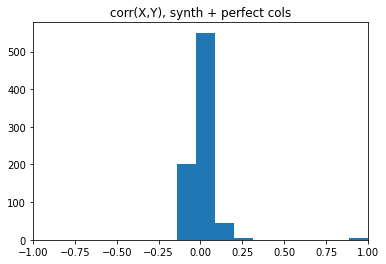

In [175]:
plt.hist(top_corr_y);
plt.xlim(-1,1); plt.title(f'corr(X,Y), synth + perfect cols');

### bring in fastai.Tab

In [239]:
dft = pd.concat((pd.DataFrame(xxp), 
                 pd.DataFrame(yy, columns=['y']))
                , axis=1)
dft.columns = [str(e) for e in dft.columns]

In [240]:
lo, hi = dft['y'].min(), dft['y'].max()
lo, hi

(-1678.8361342706023, 1449.6544377514724)

#### first make it work well with small feature set
y_range?

In [222]:
load_df = dft.iloc[:, -20:]

dls = TabularDataLoaders.from_df(load_df, 
                                 y_names = ["y"],
                                 procs=[])

In [235]:
learn = tabular_learner(dls,y_range=(lo, hi), metrics=[R2Score()])

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=1.9054607491852948e-06)

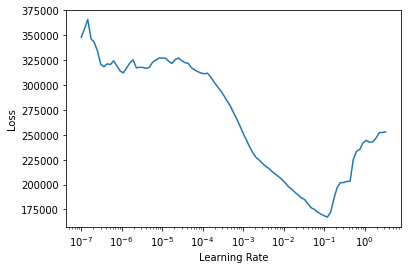

In [236]:
learn.lr_find()

In [238]:
learn.fit(10, lr=1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,8486.479492,3321.505127,0.981065,00:00
1,7155.039551,1734.019897,0.990115,00:00
2,7176.754395,2536.987305,0.985538,00:00
3,7303.182617,1968.325439,0.988779,00:00
4,6552.144531,2009.082642,0.988547,00:00
5,6646.380859,1433.534058,0.991828,00:00
6,6390.269043,1491.546997,0.991497,00:00
7,6517.528809,1655.837280,0.990561,00:00
8,6160.200195,1626.742798,0.990727,00:00
9,6251.080078,1418.603516,0.991913,00:00


#### then make it fail on large feature set

Normalize y?

In [241]:
load_df = dft.iloc[:, -400:]

dls = TabularDataLoaders.from_df(load_df, 
                                 y_names = ["y"],
                                 procs=[])

In [242]:
learn = tabular_learner(dls,y_range=(lo, hi), metrics=[R2Score()])

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0008317637839354575)

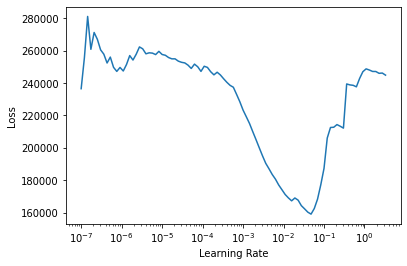

In [243]:
learn.lr_find()

In [244]:
learn.fit(10, lr=1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,195308.875000,127402.773438,0.397375,00:00
1,107184.257812,71973.554688,0.659560,00:00
2,73931.539062,61197.171875,0.710533,00:00
3,55336.207031,68907.171875,0.674064,00:00
4,42752.097656,61669.855469,0.708297,00:00
5,34893.765625,56035.601562,0.734947,00:00
6,28368.812500,56588.585938,0.732332,00:00
7,23988.671875,59008.597656,0.720885,00:00
8,20191.519531,58537.613281,0.723113,00:00
9,17377.234375,56214.371094,0.734102,00:00


#### fail hard, big set

In [254]:
load_df = dft.iloc[:,:]

dls = TabularDataLoaders.from_df(load_df, 
                                 y_names = ["y"],
                                 procs=[Normalize])

In [255]:
learn = tabular_learner(dls,y_range=(lo, hi), metrics=[R2Score()])

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0014454397605732083)

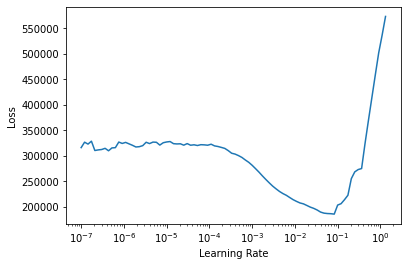

In [256]:
learn.lr_find()

In [257]:
learn.fit(10, lr=5e-3)

epoch,train_loss,valid_loss,r2_score,time
0,176573.625000,93669.460938,0.586175,00:00
1,135289.218750,85621.031250,0.621732,00:00
2,95414.968750,54777.917969,0.757995,00:00
3,70121.023438,57846.386719,0.744439,00:00
4,54573.714844,49140.261719,0.782902,00:00
5,45005.699219,60607.320312,0.732241,00:00
6,37940.144531,56693.265625,0.749533,00:00
7,32533.726562,61720.929688,0.727321,00:00
8,27816.359375,57962.269531,0.743927,00:00
9,24134.810547,67656.757812,0.701097,00:00


### Does this occur when other columns are non-correlated with y?
Yes. Therefore the problem isn't so much multi-collinearity but with the sheer number of features, or perhaps the depth?

In [258]:
rand_xx = np.random.rand(*xx.shape)
rand_xx.shape

(700, 800)

In [259]:
rand_xxp = np.concatenate((rand_xx,perfect_preds.T), axis=1)
rand_xxp.shape

(700, 804)

In [260]:
dft2 = pd.concat((pd.DataFrame(rand_xxp), 
                 pd.DataFrame(yy, columns=['y']))
                , axis=1)
dft2.columns = [str(e) for e in dft2.columns]

#### Fit it

In [288]:
load_df = dft2

dls = TabularDataLoaders.from_df(load_df, 
                                 y_names = ["y"],
                                 procs=[Normalize])

learn = tabular_learner(dls,y_range=(lo, hi), metrics=[R2Score()])

learn.fit(10, lr=5e-3)

epoch,train_loss,valid_loss,r2_score,time
0,202495.281250,141766.375000,0.331324,00:00
1,160740.531250,132597.781250,0.374570,00:00
2,115472.750000,96388.500000,0.545360,00:00
3,85887.984375,96427.429688,0.545176,00:00
4,66329.585938,83946.757812,0.604044,00:00
5,52609.300781,88989.343750,0.580260,00:00
6,42506.125000,85216.273438,0.598056,00:00
7,35332.089844,93079.039062,0.560970,00:00
8,29142.078125,86132.171875,0.593736,00:00
9,25042.361328,91524.945312,0.568300,00:00


In [346]:
load_df = dft2

dls = TabularDataLoaders.from_df(load_df, 
                                 y_names = ["y"],
                                 procs=[Normalize])

learn = tabular_learner(dls,y_range=(lo, hi), metrics=[R2Score()])

learn.fit(30, lr=1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,197948.406250,171671.031250,0.185330,00:00
1,114377.187500,131948.921875,0.373833,00:00
2,78246.054688,122165.640625,0.420259,00:00
3,57971.695312,122200.445312,0.420094,00:00
4,44706.773438,114547.421875,0.456412,00:00
5,35227.402344,111779.164062,0.469549,00:00
6,28785.972656,112612.289062,0.465595,00:00
7,23806.205078,113688.085938,0.460490,00:00
8,20207.701172,110735.257812,0.474503,00:00
9,17319.080078,113364.710938,0.462025,00:00


### another experiment: maybe the problem is the init of the weights?
What if we added weight decay?

In [298]:
load_df = dft2

dls = TabularDataLoaders.from_df(load_df, 
                                 y_names = ["y"],
#                                  procs=[Normalize])
                                 procs=[])

learn = tabular_learner(dls,
                        y_range=(lo, hi), 
                        metrics=[R2Score()], 
#                         wd=1e-1,
#                         train_bn=False,
                        opt_func=RMSProp,
                       )

In [299]:
# learn.lr_find()

In [300]:
learn.fit(10, lr=1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,204633.859375,84715.867188,0.590088,00:00
1,130663.250000,95629.578125,0.537280,00:00
2,87322.023438,101047.296875,0.511066,00:00
3,63404.640625,104508.023438,0.494320,00:00
4,47808.261719,112574.210938,0.455291,00:00
5,37420.000000,109464.085938,0.470339,00:00
6,30452.804688,111956.562500,0.458279,00:00
7,25559.990234,113465.843750,0.450976,00:00
8,21754.902344,116054.882812,0.438449,00:00
9,18899.029297,112024.085938,0.457952,00:00


In [350]:
load_df = dft2

dls = TabularDataLoaders.from_df(load_df, 
                                 y_names = ["y"],
#                                  procs=[Normalize])
                                 procs=[])

learn = tabular_learner(dls,
                        y_range=(lo, hi), 
                        metrics=[R2Score()], 
#                         wd=1e-1,
#                         train_bn=False,
                        opt_func=RMSProp,
                       )

In [348]:
learn.fit(30, lr=1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,184394.187500,80934.539062,0.589434,00:00
1,120421.429688,86155.367188,0.562950,00:00
2,81521.671875,92688.671875,0.529808,00:00
3,59060.121094,89381.750000,0.546583,00:00
4,45013.605469,98837.648438,0.498615,00:00
5,35302.503906,96894.125000,0.508474,00:00
6,28878.384766,95415.085938,0.515977,00:00
7,23887.662109,96592.960938,0.510002,00:00
8,20206.695312,97312.960938,0.506350,00:00
9,17757.923828,98956.250000,0.498014,00:00


In [351]:
learn.fit(30, lr=1e-4)

epoch,train_loss,valid_loss,r2_score,time
0,228503.156250,209801.296875,0.096857,00:00
1,146295.078125,190874.296875,0.178333,00:00
2,106708.523438,171627.828125,0.261184,00:00
3,80569.578125,158728.343750,0.316713,00:00
4,62962.050781,154138.281250,0.336472,00:00
5,49922.871094,151072.421875,0.349670,00:00
6,40473.257812,148621.109375,0.360223,00:00
7,33582.296875,146176.437500,0.370746,00:00
8,28501.658203,144606.281250,0.377505,00:00
9,24000.714844,142855.484375,0.385042,00:00


### Bring in BaseNet, fit it

In [336]:
from module2.mnist_models import BaseNet, TabNet

In [337]:
tn = TabNet(lo=lo, hi=hi)

In [345]:
TabularModel()

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(804, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(804, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=804, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=-1678.8361342706023, high=1449.6544377514724)
  )
)

In [338]:
tn

TabNet(
  (linear1): Linear(in_features=804, out_features=28, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=28, out_features=2, bias=False)
  (sig): SigmoidRange(low=-1678.8361342706023, high=1449.6544377514724)
)

In [344]:
tab_m = TabularModel(1, 804, 1,)

TypeError: 'int' object is not iterable

In [341]:
# l = Learner(dls, tn, )
l = TabularLearner(dls, tn, )

In [342]:
l.fit(1)

TypeError: forward() takes 2 positional arguments but 3 were given

In [352]:
lo, hi

(-1678.8361342706023, 1449.6544377514724)

### Examine Model, set weights to 0

In [303]:
m = learn.model

In [319]:
m

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(804, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(804, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=804, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=-1678.8361342706023, high=1449.6544377514724)
  )
)

In [305]:
type(m)

fastai.tabular.model.TabularModel

In [310]:
sd = m.layers[0][1].state_dict()

In [312]:
sd['weight'].shape

torch.Size([200, 804])

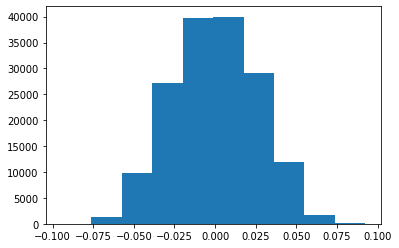

In [318]:
plt.hist(sd['weight'].flatten().numpy());